# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Load data + create classes
We transform the original wine quality scores (0–10) into 4 broader categories. This reduces class imbalance and makes the classification task easier for the model.

In [2]:
df = pd.read_csv("winequality-red.csv")

def map_quality(q):
    if q <= 4:            # Quality 0-4
        return 0
    elif q == 5:          # Quality 5
        return 1
    elif q == 6:          # Quality 6
        return 2
    else:                 # Quality 7-10
        return 3

df["quality_class"] = df["quality"].apply(map_quality) # Creating a new target column with grouped wine quality categories.

X = df.drop(columns=["quality", "quality_class"]) # X contains model features.
y = df["quality_class"]                           # y is the new class label to predict.

# Train-test split
Splitting data into training and test sets.


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=10
)

# Synthetic Minority Oversampling Technique (SMOTE)
SMOTE creates synthetic minority classes to balance the training data.
This helps prevent the model from favoring majority classes.


In [4]:
smote = SMOTE(random_state=10, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Grid Search (RandomForest)
We perform hyperparameter tuning by testing multiple Random Forest settings and select the model that achieves the best weighted multi-class ROC-AUC score.

In [5]:
rf = RandomForestClassifier(random_state=10) # Creating a Random Forest classifier.

param_grid = {  # The hyperparameter combinations we are trying.
    "n_estimators": [300,350],
    "max_depth": [None,10],
    "min_samples_split": [2, 3],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt"],
    "class_weight": [None]
}

grid = GridSearchCV(  # Testing multiple hyperparameter combinations to find the best model.
    rf,
    param_grid=param_grid,
    scoring="roc_auc_ovr_weighted",
    cv=3, # 3-fold cross-validation
    n_jobs=-1, # use all CPU cores
)

grid.fit(X_train_resampled, y_train_resampled) # Training models and selecting the best configuration.
best = grid.best_estimator_

# Results

Best parameters: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 350}
AUC (micro): 0.9043180338541668
AUC (macro): 0.8598929624481028
AUC (weighted): 0.868788236486498


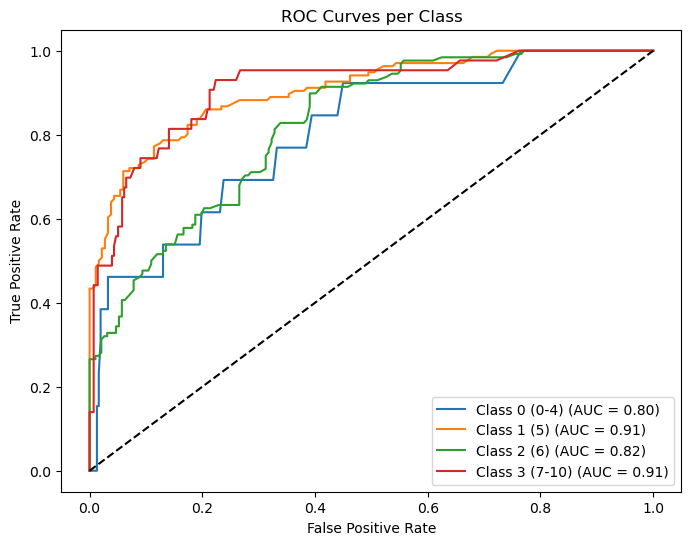

In [6]:
print("Best parameters:", grid.best_params_)

y_proba = best.predict_proba(X_test)# Predicting probabilities on test set

classes = sorted(y.unique()) # Converting labels into binary format for multi-class ROC-AUC
y_test_bin = label_binarize(y_test, classes=classes)

# Micro AUC: Computes AUC globally by counting all true positives / false positives together.
auc_micro = roc_auc_score(
    y_test_bin,
    y_proba,
    average="micro",
    multi_class="ovr"
)

# Macro AUC: Computes AUC for each class separately and takes the unweighted mean (all classes equal).
auc_macro = roc_auc_score(
    y_test_bin,
    y_proba,
    average="macro",
    multi_class="ovr"
)

# Weighted AUC: Computes AUC for each class and averages them weighted by class frequency.
auc_weighted = roc_auc_score(
    y_test_bin,
    y_proba,
    average="weighted",
    multi_class="ovr"
)
print("AUC (micro):", auc_micro)
print("AUC (macro):", auc_macro)
print("AUC (weighted):", auc_weighted)

class_labels = ["0-4", "5", "6", "7-10"]  # Define class labels that correspond to the quality metrics
plt.figure(figsize=(8,6))

for i in range(y_test_bin.shape[1]): # Loop through each class to plot its ROC curve
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_proba[:,i])  # Compute false positive rate and true positive rate
    plt.plot(fpr, tpr, label=f"Class {i} ({class_labels[i]}) (AUC = {auc(fpr,tpr):.2f})")  # Plot ROC curve with AUC in legend

plt.plot([0,1],[0,1],'k--')  # Diagonal line representing random classifier
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Class")
plt.legend()
plt.show()